### Code sandbox for elastic wave equation / pseudo-elastic

### Let's take a look at Devito's Elastic Example

The elastic example can be found [here](https://github.com/devitocodes/devito/tree/master/examples/seismic/elastic). Some equations I found on there - 

$$
\frac{\partial}{\partial t} v - \frac{1}{\rho} \nabla \mathbf{.} \tau = 0
$$

**Note:** RHS should be a source term(?) maybe not 0
$$
\frac{\partial}{\partial t} \tau - \lambda \text{diag}(\nabla . v) - \mu \left( \nabla v + (\nabla v)^T \right) = 0
$$

Let's compare this with the derivation [here](https://wiki.seg.org/wiki/Mathematical_foundation_of_elastic_wave_propagation#math_L-34).

Different formulation here, assumes $\lambda$ and $\mu$ are fixed - 
$$
\rho \frac{\partial^2 \mathbf{u}}{\partial t^2} = (\lambda + \mu) \nabla \Delta + \mu \nabla^2 \mathbf{u} \;\;\;\; \mathbf{(1)}
$$

$$
\mathbf{u} = 
\begin{pmatrix}
    u\\
    v\\
    w\\
\end{pmatrix},\;\;\; \Delta = \left( \frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} + \frac{\partial w}{\partial z} \right)
$$

with some effort, we can convert to this format - 

$$
\rho \frac{\partial^2 \Delta}{\partial t^2} = (\lambda + \mu) \nabla^2 \Delta  \;\;\;\; \mathbf{(2)}
$$

this is called the *dilatational* or *compressional-wave* propagation. It can be derived from the earlier succinctly by noting that 
$$
\Delta = \nabla  \mathbf{. u}
$$

This represents a compressional wave propagating with a speed 

$$
v_{p} = \alpha = \sqrt{\frac{(\lambda + \mu)}{\rho}}
$$

We can also define a rotational vector 
$$
\Theta := \begin{pmatrix}
\theta_{xy}\\
\theta_{xz}\\
\theta_{yz}
\end{pmatrix}
$$
and take the curl of **(1)**, to get

$$
\rho \frac{\partial^2}{\partial t^2} \Theta = \mu \nabla^{2} \Theta \;\;\;\;\; \mathbf{(3)}
$$
propagating at speed
$$
v_{s} = \beta = \sqrt{\frac{\mu}{\rho}}
$$

**(2)** represents the P-wave, and **(3)** represents the S-wave propagation. We should now have enough information to figure out what that Devito example is doing.

To recap, here's what Devito does - 

$$
\frac{\partial}{\partial t} \mathbf{v} - \frac{1}{\rho} \nabla \mathbf{.} \tau = 0 \;\;\;\; \mathbf{(4)}
$$

$$
\frac{\partial}{\partial t} \tau - \lambda \text{diag}(\nabla . \mathbf{v}) - \mu \left( \nabla \mathbf{v} + (\nabla \mathbf{v})^T \right) = 0
\;\;\;\; \mathbf{(5)}
$$
**Note**: diag(x) means form a diagonal matrix, using the entries of x on the principal diagonal

To get **(4)** from **(1)**, first we define 
$$
\mathbf{v} = \frac{\partial}{\partial t} \mathbf{u} \;\;\;\;\;\; \tau = ?
$$

Now replace $\mathbf{u}$ with $v$, and divide by $\rho$ in the equation to get
$$
\frac{\partial \mathbf{v}}{\partial t} = \frac{1}{\rho}\left( (\lambda + \mu) \nabla \Delta + \mu \nabla^2 \mathbf{u} \right)
$$
therefore
$$
\nabla \mathbf{.} \tau = \left( (\lambda + \mu) \nabla \Delta + \mu \nabla^2 \mathbf{u} \right)
$$

for more insight on what $\tau$ even is, we can look at **(5)** and write it in terms of $\mathbf{u}$ - 
$$
\frac{\partial}{\partial t} \tau - \lambda \text{diag}(\nabla . \frac{\partial \mathbf{u}}{\partial t}) - \mu \left( \nabla \frac{\partial \mathbf{u}}{\partial t} + \left(\nabla \frac{\partial \mathbf{u}}{\partial t}\right)^T \right) = 0
$$

$$
\implies \tau - \lambda \text{diag}\left(\nabla \mathbf{. u} \right) - \mu (\nabla \mathbf{u} + (\nabla \mathbf{u})^T) = 0
$$

$$
\implies \tau = \lambda \text{diag}\left(\nabla \mathbf{. u} \right) + \mu (\nabla \mathbf{u} + (\nabla \mathbf{u})^T)
$$

$$
\implies \tau = \lambda \text{diag}\left(\nabla \mathbf{. u} \right) + 2\mu (\mathbf{e_{ij}})
$$

$$
\implies \tau = \lambda . 
\begin{pmatrix}
{\frac{\partial u}{\partial x}} & {0} & {0} \\
{0} & {\frac{\partial v}{\partial y}} & {0} \\
{0} & {0} & {\frac{\partial w}{\partial z}} \\
\end{pmatrix}
+ 2\mu (\mathbf{e_{ij}})
$$

$$
\implies \tau = \lambda . 
\begin{pmatrix}
{\frac{\partial u}{\partial x}} & {0} & {0} \\
{0} & {\frac{\partial v}{\partial y}} & {0} \\
{0} & {0} & {\frac{\partial w}{\partial z}} \\
\end{pmatrix}
+ 2\mu .\begin{pmatrix}
{2\frac{\partial u}{\partial x}} & 
{\frac{\partial v}{\partial x} + \frac{\partial u}{\partial y}} &
{\frac{\partial w}{\partial x} + \frac{\partial u}{\partial z}} \\
{\frac{\partial u}{\partial y} + \frac{\partial v}{\partial x}} & 
{2\frac{\partial v}{\partial y}} &
{\frac{\partial w}{\partial y} + \frac{\partial v}{\partial z}} \\
{\frac{\partial u}{\partial z} + \frac{\partial w}{\partial x}} &
{\frac{\partial v}{\partial z} + \frac{\partial w}{\partial y}} &
{2\frac{\partial w}{\partial z}} \\
\end{pmatrix}
$$

This lines up with [this](https://wiki.seg.org/wiki/Mathematical_foundation_of_elastic_wave_propagation#equation_L-21)

### Pseudo-elastic Equation

From Sun et al.(2021), we now attempt to derive the pseudo-elastic pure P-wave equation so as to figure out how we might implement it in Devito.

Start off as before, we define 
$$
\mathbf{u} = [u_x, u_y, u_z]^T;\;\;\; 
\mathbf{f} = [f_x, f_y, f_z]^T;\;\;\;
\mathbf{m} = [m_{xx}, m_{yy}, m_{zz}, m_{xy}, m_{xz}, m_{yz}]^T
$$
where $\mathbf{m}$ is the moment-density tensor that acts like a source term for the components of the stress tensor. Then, we have the original elastic equation - 

$$
\partial_{t}^2 \mathbf{u} = \mathbf{E}\mathbf{u} + \frac{1}{\rho} (\mathbf{f} + \nabla . \mathbf{m})
\;\;\;\;\; \mathbf{(6)}
$$

$\mathbf{E}$ is defined as -

$$
\mathbf{E} = \frac{1}{\rho} 
\begin{bmatrix}
{\partial_{x}(\lambda + 2\mu)\partial_{x} + \partial_{y}\mu\partial_{y} + \partial_{z}\mu\partial_{z}} & 
{\partial_{x}\lambda\partial_{y} + \partial_{y}\mu\partial_{x}} &
{\partial_{x}\lambda\partial_{z} + \partial_{z}\mu\partial_{x}} \\
{\partial_{y}\lambda\partial_{x} + \partial_{x}\mu\partial_{y}} & 
\partial_{x}\mu\partial_{x} + \partial_{y}(\lambda + 2\mu)\partial_{y} + \partial_{z}\mu\partial_{z} &
\partial_{y}\lambda\partial_{z} + \partial_{z}\mu\partial_{y} \\
{\partial_{z}\lambda\partial_{x} + \partial_{x}\mu\partial_{z}} & 
\partial_{z}\lambda\partial_{y} + \partial_{y}\mu\partial_{z} &
\partial_{x}\mu\partial_{x} + \partial_{y}\mu\partial_{y} + \partial_{z}(\lambda + 2\mu)\partial_{z} \\
\end{bmatrix}
$$

Now, we introduce a normalized gradient / divergence operator - 

$$
\tilde{\nabla} = \begin{bmatrix}
\frac{\partial_{x}}{\sqrt{\partial_{x}^2 + \partial_{y}^2 + \partial_{z}^2}}\\
\frac{\partial_{y}}{\sqrt{\partial_{x}^2 + \partial_{y}^2 + \partial_{z}^2}}\\
\frac{\partial_{z}}{\sqrt{\partial_{x}^2 + \partial_{y}^2 + \partial_{z}^2}}
\end{bmatrix}
$$

From this definition, we have that $\tilde{\nabla} \mathbf{.} \tilde{\nabla} = \mathbf{I}$. We can now substitute this into $\mathbf{(6)}$


$$
\partial_{t}^2 \mathbf{u} = \mathbf{E} (\tilde{\nabla} \tilde{\nabla}) \mathbf{.} \mathbf{u} + \frac{1}{\rho} (\mathbf{f} + \nabla . \mathbf{m})
\;\;\;\;\; \mathbf{(7)}
$$

We can now define $P = \tilde{\nabla} \;\mathbf{.}\; \mathbf{u}$, and take the normalized divergence on both sides to get

$$
\partial_{t}^2 P = \tilde{\nabla} \; \mathbf{.}\; \mathbf{E} \tilde{\nabla} P + \tilde{\nabla} \mathbf{.} \frac{1}{\rho}(\mathbf{f} + \nabla \mathbf{.} \mathbf{m})
\;\;\;\;\; \mathbf{(8)}
$$


### Questions

1. What exactly is $\mathbf{m}$ - moment-density tensor? (I assume it's some sort of source term for the stress tensor)


2. What are the actual inputs and outputs to the FFT subroutines? Currently just treating these as black boxes that somehow come up with the weights they describe for the spatial derivatives. Going to count "1" FFT for each operator involving $\tilde{\nabla}$. In reality, we must find a way to apply FFTs across each dimension for each grid point.
    
    **I. 1st-Order Equation**
    [Eq(8) in Sun et al.(2021)]

    a. $P = \tilde{\nabla} \mathbf{. u}$ needs to be computed which needs an FFT. We know $\mathbf{u}(t_0)$ so this shouldn't really be very hard to compute.

    b. Then we need to compute 3 more applications of the normalized gradient/divergence operator to each row of $\tau$ and $f$. 

    c. We also need the FFT decomposition of $P$ for the $\tau$ update, which is 1 more FFT.

    d. Not counting the initial $P$ computation, at each time-step, we would need to apply Fourier analysis to 3 fields that are a function of $\tau$ and $f$, and also to $P$. That gives us $4$ domain-wide FFTs (and inverse FFTs) at each time step.
    
    **II. 2nd-Order Equation**
$$
\partial_{t}^2 P = \tilde{\nabla} \; \mathbf{.}\; \mathbf{E} \tilde{\nabla} P + \tilde{\nabla} \mathbf{.} \frac{1}{\rho}(\mathbf{f} + \nabla \mathbf{.} \mathbf{m})
$$

    a. $P = \tilde{\nabla} \mathbf{. u}$ needs to be computed which needs an FFT. We know $\mathbf{u}(t_0)$ so this shouldn't really be very hard to compute.

    b. Then we need to compute $\tilde{\nabla} \mathbf{. E} \tilde{\nabla}P$, that is 2 more domain-wide FFTs at each iteration.

    c. We also need $\tilde{\nabla}\frac{1}{\rho}(\mathbf{f} + \nabla \mathbf{. m})$, which is 1 more FFT. Given we know the source terms, we should be able to pre-compute this across all time-steps.

    d. That gives us a total of 2 domain-wide FFTs each iteration in the second-order formulation. At each time-step, we need to compute the FFT of $P$ and also of $E \tilde{\nabla} P$, with their respective inverses.


3. When they say $\partial_{x}^2$, do they mean a second derivative or do they mean the square of the first derivative? I'm assuming because of how the terms are described in wavenumber domain that they mean the square of the first derivative. Also does this change how many FFTs we have to do?


4. If I wanted to do this in $2$-D, would I be able to get away by just dropping all $y$-terms?


5. If we assume as many FFTs as possible are pre-computed, what terms can we assume are fully-defined before passing over to Devito? Considering 
$$
\partial_{t}^2 P = \tilde{\nabla} \; \mathbf{.}\; \mathbf{E} \tilde{\nabla} P + \tilde{\nabla} \mathbf{.} \frac{1}{\rho}(\mathbf{f} + \nabla \mathbf{.} \mathbf{m})
$$
we can assume we have $P$ and $\tilde{\nabla} \mathbf{.} \frac{1}{\rho}(\mathbf{f} + \nabla \mathbf{.} \mathbf{m})$ at every iteration. If $\mathbf{f}$ is a known source-term, then presumably we can precompute the latter term across all time? Then we still need to decompose $P$ and $E \tilde{\nabla} P$ with FFTs at each iteration for the pseudo-elastic equation.


6. Conversion to anisotropy. Consider the anistropic equation (as a single PDE) - 
$$
\frac{1}{\rho v_{p}^{2}} \frac{\partial^2 P}{\partial t^2} = (1 + 2\varepsilon)\mathbf{H}P + \mathbf{H}_{0}P
- 2(\varepsilon - \delta)\mathbf{H}_{0}(\mathbf{H}+\mathbf{H}_{0})^{-1} \mathbf{H} P + \frac{S}{\rho}
$$
where

$$
\mathbf{H} \equiv \left[\frac{\partial}{\partial x} \frac{1}{\rho}\frac{\partial }{\partial x} + \frac{\partial}{\partial y} \frac{1}{\rho} \frac{\partial }{\partial y} \right]
$$

$$
\mathbf{H}_{0} \equiv \left[\frac{\partial}{\partial z}\frac{1}{\rho}\frac{\partial }{\partial z} \right]
$$

$$
\mathbf{H} + \mathbf{H}_{0} = \nabla . \frac{1}{\rho} \nabla
$$

In wavenumber domain, we might be able to compute $(\mathbf{H} + \mathbf{H}_{0})^{-1}$ efficiently with FFTs.

In [15]:
import numpy as np
%matplotlib inline

from devito import Grid, Function, TimeFunction, SparseTimeFunction, solve, Eq, Operator, Buffer
from examples.seismic import Model, plot_velocity, TimeAxis, RickerSource, Receiver, AcquisitionGeometry

In [53]:
dim = 2
shape = (51, 51)
spacing = (10, 10)
origin = (0, 0)
nbl = 4
space_order = 2
time_order = 2

vp_initial = np.ones(shape)
b_initial = np.ones(shape)
vs_initial = 0.8 * vp_initial


model = Model(origin, spacing, shape, space_order, vp_initial,
              nbl=nbl, bcs="damp",
              b=b_initial, vs=vs_initial)

dt = model.critical_dt
print("Critical dt: {:.4f}ms".format(dt))

t0 = 0
tn = 1000
time_range = TimeAxis(start=t0, stop=tn, step=dt)
u = TimeFunction(name='u', grid=model.grid, space_order=space_order, time_order=time_order,
                 save=Buffer(time_range.num))

Operator `initdamp` ran in 0.01 s
Operator `pad_lam` ran in 0.01 s
Operator `pad_mu` ran in 0.01 s
Operator `pad_b` ran in 0.01 s


Critical dt: 7.0710ms


In [54]:
src_coords = np.array([(shape[i]-1) * spacing[i] / 2 for i in range(dim)])
n_recv = 5
recv_coords = np.zeros((n_recv, dim))
line_dim = 1         # Space out receivers in this dimension
for j in range(n_recv):
    recv_coords[j, :] = [(shape[i]-1) * spacing[i] / 2 for i in range(dim)]
    recv_coords[j, line_dim] = j / (n_recv - 1) * (shape[line_dim]-1) * spacing[line_dim]

# print(src_coords, recv_coords)
# Source in the center of the model at 10 Hz center frequency
fpeak = 0.010
src = RickerSource(name='src', grid=model.grid, f0=fpeak, npoint=1, time_range=time_range)
src.coordinates.data[:] = src_coords
rec = Receiver(name='rec', grid=model.grid, npoint=n_recv, time_range=time_range)
rec.coordinates.data[:] = recv_coords
print(src_coords, "\n", recv_coords)

[250. 250.] 
 [[250.   0.]
 [250. 125.]
 [250. 250.]
 [250. 375.]
 [250. 500.]]


(59, 59) complex64
-118.69598 118.69598
-114.03578 107.87387


Text(0.5,1,'fft$^{-1}$(fft($u$)) at $t=0$')

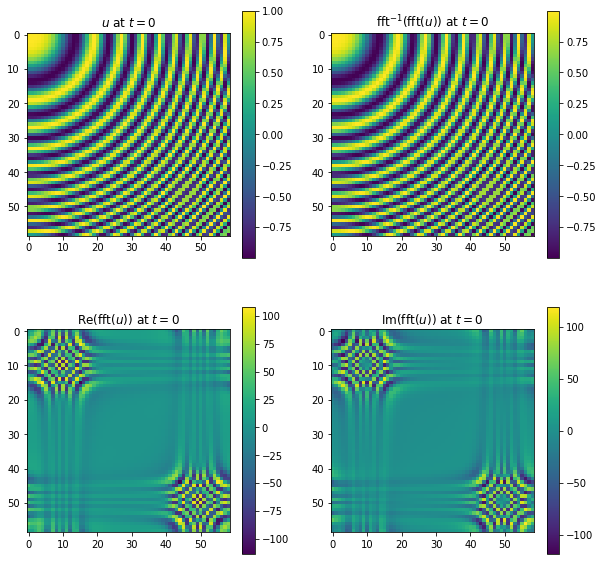

In [68]:
from scipy.fft import fftn, ifftn, fft, ifft, fft2, ifft2
import matplotlib.pyplot as plt

def set_ic(u):
    for i in range(u.shape[0]):
        x = i / (u.shape[0]-1)
        for j in range(u.shape[1]):
            y = j / (u.shape[1]-1)
            u[i, j] = np.cos(i * x + j * y)
    return u

u.data[0] = set_ic(u.data[0])
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
plot_00 = axs[0, 0].imshow(u.data[0])
axs[0, 0].set_title(r"$u$ at $t=0$")
cbar00 = fig.colorbar(plot_00, ax=axs[0, 0])

u_fft = fft2(u.data[0])
print(u_fft.shape, u_fft.dtype)
print(np.min(np.imag(u_fft)), np.max(np.imag(u_fft)))
print(np.min(np.real(u_fft)), np.max(np.real(u_fft)))
lvs = np.linspace(np.min(np.imag(u_fft)), np.max(np.imag(u_fft)), 100)
# print(lvs)
plot_01 = axs[1, 1].imshow(np.imag(u_fft))
cbar01 = fig.colorbar(plot_01, ax=axs[1, 1])
axs[1, 1].set_title(r"Im(fft($u$)) at $t=0$")

plot_10 = axs[1, 0].imshow(np.real(u_fft))
cbar10 = fig.colorbar(plot_10, ax=axs[1, 0])
axs[1, 0].set_title(r"Re(fft($u$)) at $t=0$")

u_recom = ifft2(u_fft)
plot_11 = axs[0, 1].imshow(np.real(u_recom))
cbar11 = fig.colorbar(plot_11, ax=axs[0, 1])
axs[0, 1].set_title(r"fft$^{-1}$(fft($u$)) at $t=0$")
# vp_transform
